In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm
from tqdm import tqdm
import librosa
import librosa.display
import IPython.display as ipd

import random

In [2]:
#loading data
data = np.load("normalizedCutDATA.npy")

In [3]:
#taking a sample size of 10,000
#8:2 split (training_data:testing_data ratio)
np.random.shuffle(data)
training_data = data[:8000] #length of 8000
testing_data = data[8000:10000] #length of 2000

In [4]:
transform = transforms.ToTensor()

In [5]:
class CAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential( #starting size: (10,431)
            nn.Conv2d(1,32,3), #input: 10, 431 -> 8,429
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3), #input: 4, 214 -> 2,212
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2) #input: 2, 212 -> 1, 106
            #final: 1, 106
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2), #input: 1,106 -> 3,213
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, (6,7), stride=2), #input: 3, 213 -> 10,431
            
            #final: 10,431
        )
        
    def forward(self,x):
        x = self.encoder(x)
        x=self.decoder(x)
        return x

In [6]:
#creating the batches

BATCH_SIZE = 32
BATCHES = []

copy = training_data.tolist()

iterations = int((len(copy))/BATCH_SIZE)
for i in range(iterations):
    start = random.randint(0, len(copy) - BATCH_SIZE)
    end = start + BATCH_SIZE
    batch = copy[start:end]
    BATCHES.append(batch)
    copy = copy[:start] + copy[end:] #taking out the batch from the training_data
    #to prevent duplicate numbers from appearing across batches
   
print(len(copy))
print(f'Shape: {len(BATCHES)}, {len(BATCHES[0])}')

0
Shape: 250, 32


In [7]:
#converting the python list to tensor

batched_training_data = np.array(BATCHES)
batched_training_data = torch.from_numpy(batched_training_data).type(torch.float32)

In [8]:
#training

model = CAE()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

NUM_OF_EPOCH = 250

outputs = []

for epoch in range(NUM_OF_EPOCH):
    for i in range(len(batched_training_data)):
        output = model(batched_training_data[i].view(-1,1,10,431))
        loss = criterion(output, batched_training_data[i])
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    outputs.append((epoch, output, batched_training_data[i]))
    print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

C:\Users\JasonZhou\anaconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([32, 10, 431])) that is different to the input size (torch.Size([32, 1, 10, 431])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 165.3579
Epoch 1, Loss: 60.1968
Epoch 2, Loss: 44.4041
Epoch 3, Loss: 42.5446
Epoch 4, Loss: 41.6991
Epoch 5, Loss: 41.1762
Epoch 6, Loss: 40.7497
Epoch 7, Loss: 40.4290
Epoch 8, Loss: 40.1832
Epoch 9, Loss: 39.9938
Epoch 10, Loss: 39.8363
Epoch 11, Loss: 39.6938
Epoch 12, Loss: 39.5616
Epoch 13, Loss: 39.4455
Epoch 14, Loss: 39.3408
Epoch 15, Loss: 39.2458
Epoch 16, Loss: 39.1468
Epoch 17, Loss: 39.0443
Epoch 18, Loss: 38.9375
Epoch 19, Loss: 38.8330
Epoch 20, Loss: 38.7313
Epoch 21, Loss: 38.6278
Epoch 22, Loss: 38.5211
Epoch 23, Loss: 38.4160
Epoch 24, Loss: 38.2974
Epoch 25, Loss: 38.1796
Epoch 26, Loss: 38.0586
Epoch 27, Loss: 37.9394
Epoch 28, Loss: 37.8197
Epoch 29, Loss: 37.7012
Epoch 30, Loss: 37.5814
Epoch 31, Loss: 37.4649
Epoch 32, Loss: 37.3520
Epoch 33, Loss: 37.2439
Epoch 34, Loss: 37.1398
Epoch 35, Loss: 37.0407
Epoch 36, Loss: 36.9477
Epoch 37, Loss: 36.8593
Epoch 38, Loss: 36.7764
Epoch 39, Loss: 36.6997
Epoch 40, Loss: 36.6272
Epoch 41, Loss: 36.5581
E

In [9]:
# len(batched_training_data)

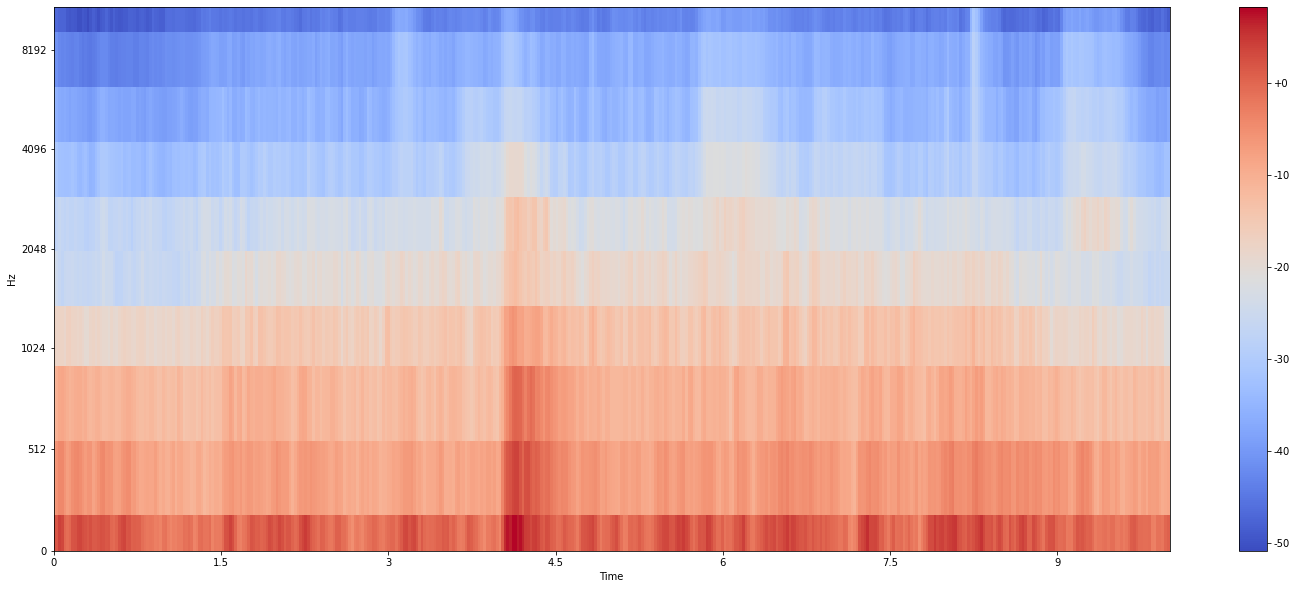

In [11]:
t = np.load("control.npy")
t = t[:, :431]
mspecTensor = torch.from_numpy(t) 
mspecTensor = model(mspecTensor.view(-1,1,10,431))
show = (t, mspecTensor)

plt.figure(figsize=(25,10))
librosa.display.specshow(show[0], x_axis = "time", y_axis = "mel", sr=22050)
#librosa.display.specshow(show[0].view(10,474).detach().numpy(), x_axis = "time", y_axis = "mel", sr=22050)

plt.colorbar(format="%+2.f")
plt.show()

In [ ]:
# show[0]

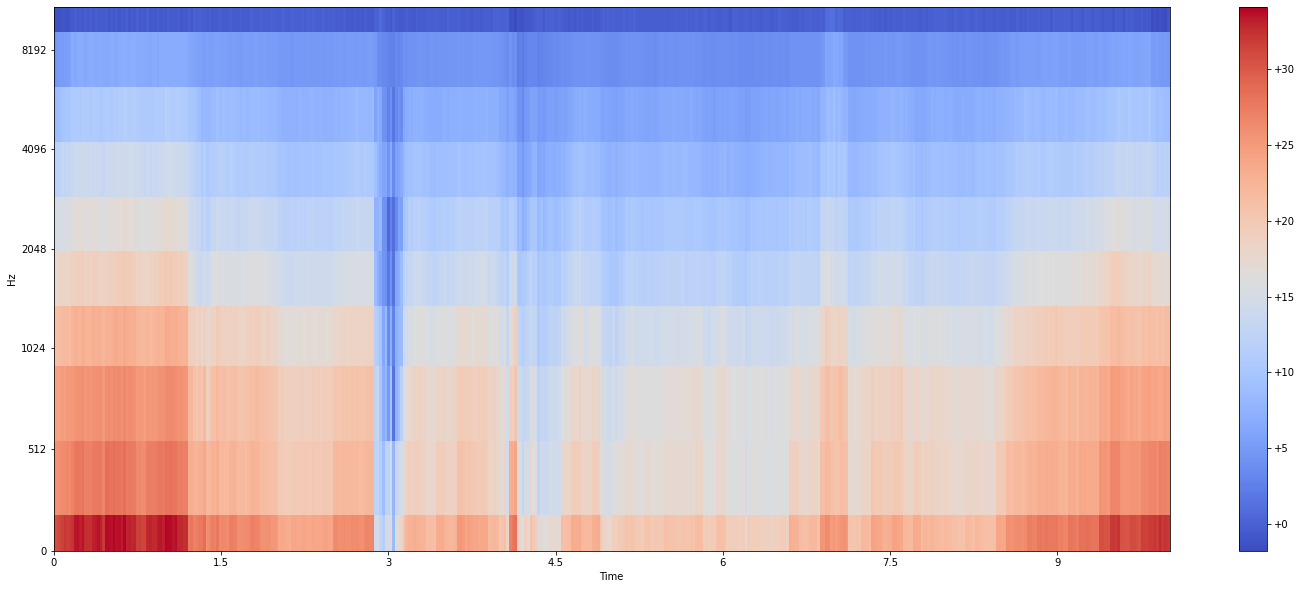

In [13]:
plt.figure(figsize=(25,10))
#librosa.display.specshow(show[0], x_axis = "time", y_axis = "mel", sr=22050)
librosa.display.specshow(show[1].view(10,431).detach().numpy(), x_axis = "time", y_axis = "mel", sr=22050)

plt.colorbar(format="%+2.f")
plt.show()

In [ ]:
# np.save("controlResult4.npy", show[1].detach().numpy())

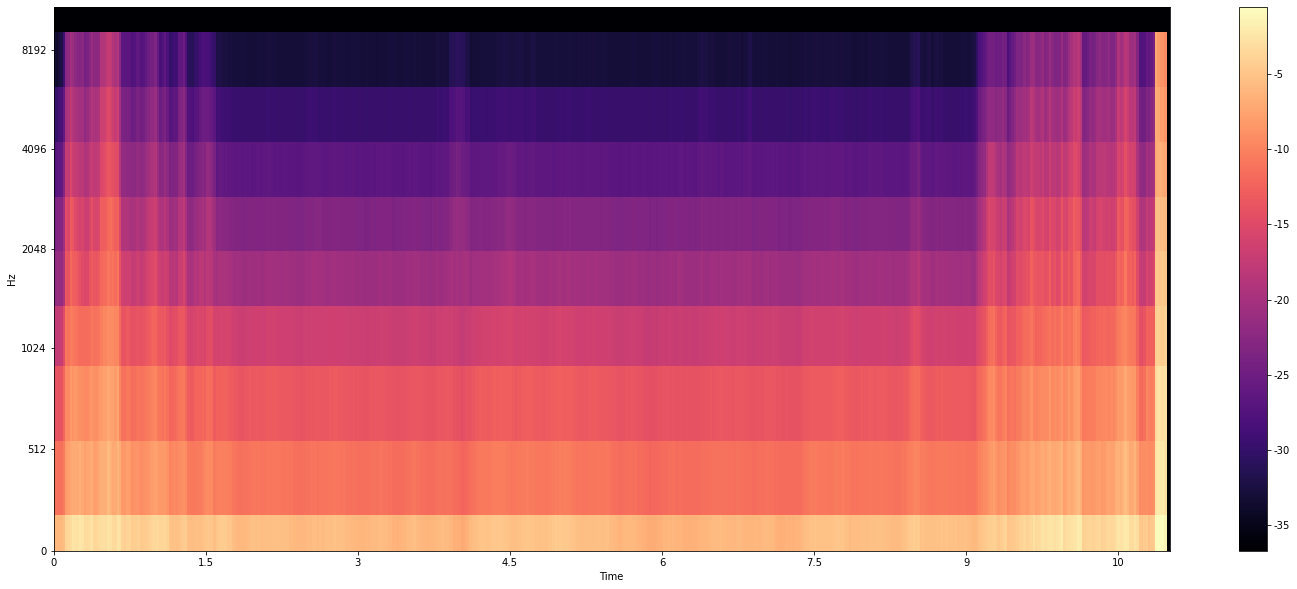

In [15]:
controlResult = np.load("controlResult.npy")
plt.figure(figsize=(25,10))
librosa.display.specshow(controlResult.reshape(10,474), x_axis = "time", y_axis = "mel", sr=22050)

plt.colorbar(format="%+2.f")
plt.show()

In [14]:
#might as well save what I have done

# path = "C:\\Users\\JasonZhou\\Models"
# torch.save(model, path)

import pickle

filename = 'model_7.pt'
pickle.dump(model, open(filename, 'wb'))

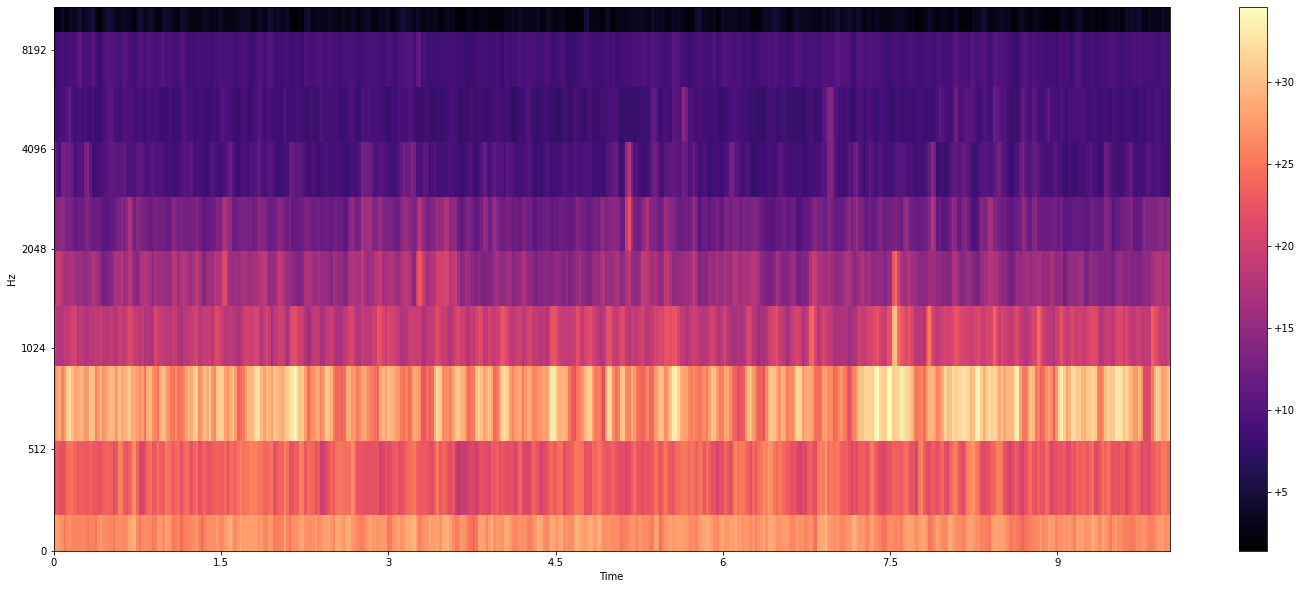

In [16]:
# controlResult = np.load("controlResult.npy")
plt.figure(figsize=(25,10))
librosa.display.specshow(testing_data[0].reshape(10,431), x_axis = "time", y_axis = "mel", sr=22050)

plt.colorbar(format="%+2.f")
plt.show()

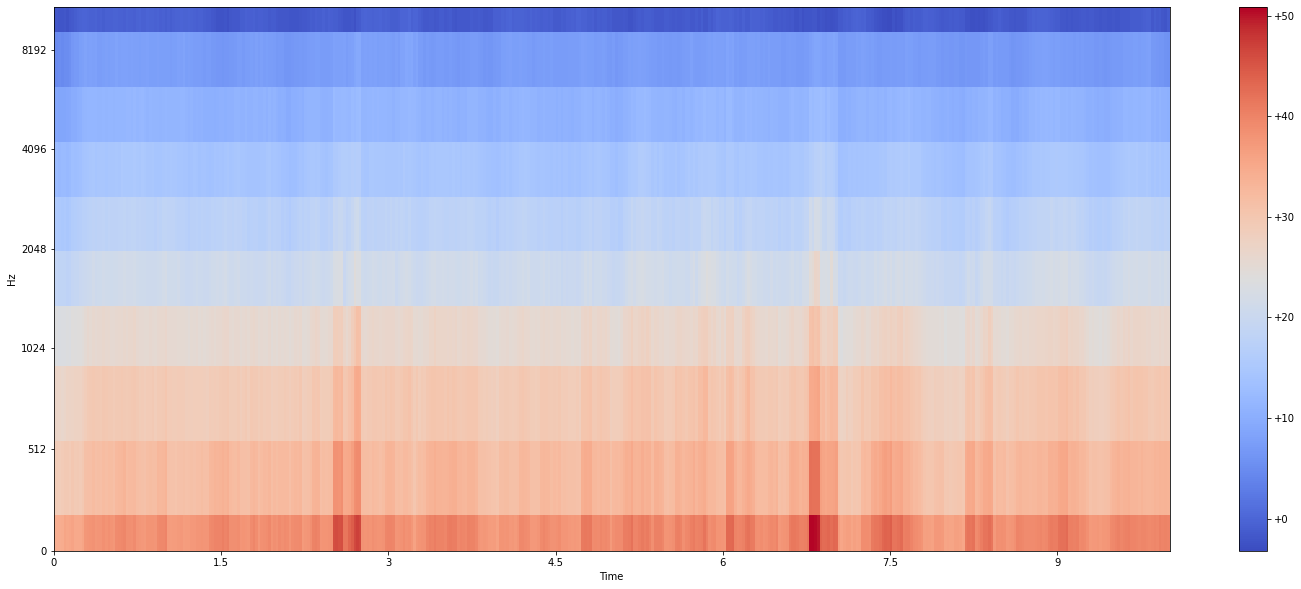

In [18]:
pic = testing_data[0]
pic = pic[:, :431]
o = torch.from_numpy(pic)
o = model(o.view(-1,1,10,431))
plt.figure(figsize=(25,10))
librosa.display.specshow(o.view(10,431).detach().numpy(), x_axis = "time", y_axis = "mel", sr=22050)

plt.colorbar(format="%+2.f")
plt.show()